In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Analisi dei dati ottenuti
Una volta concluso il vostro task e dopo aver lavorato per gli altri Requester, analizzate i
risultati ottenuti>
a. Scaricate i dati prodotti dai lavoratori utilizzando lo script di download descritto a
zione
le

1. Dati workers_acl.csv sono i dati presenti su dynamodb tabella ACL
2. worker_answers.csv sono le singole risposte alle review per ciascun worker
3. workers_dimensions_selection.csv confidence per ogni hit
4. workers_questionnaire.csv risposte alle prime due domandione

## WORKERS_ACL

In [89]:
workers_acl = pd.read_csv("/content/workers_acl.csv")
print(f"Current Number of Responses: {workers_acl.shape[0]}\n\n")

Current Number of Responses: 14




### DATI INTERESSANTI

In [90]:
interesting_columns = ['worker_id', 'unit_id','time_arrival','time_submit','time_completion']
workers_acl = workers_acl[interesting_columns]
workers_acl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   worker_id        14 non-null     object
 1   unit_id          14 non-null     object
 2   time_arrival     14 non-null     object
 3   time_submit      14 non-null     object
 4   time_completion  14 non-null     object
dtypes: object(5)
memory usage: 688.0+ bytes


### ANALISI TEMPI DI ESECUZIONE

In [ ]:
df = workers_acl.copy()
df[df['time_completion'].isna()]

,worker_id,unit_id,time_arrival,time_submit,time_completion
13,BIW8TTGRFCE0ZA,unit_4,"Tue, 16 Jan 2024 17:01:01 GMT","Tue, 16 Jan 2024 17:01:03 GMT",NaN


> Esiste un worker che non ha inviato l'output_token della unit_4 alla fine dell'esecuzione, infatti:
*   time_completion = NaN



In [ ]:
df = df[df['time_completion'].notnull()] #rimuove il worker che non ha completato

> Conversione data to timestamp() in numero di secondi da unix epoch

In [ ]:
df['time_arrival'] = [datetime.strptime(val, "%a, %d %b %Y %H:%M:%S %Z").timestamp() for val in df['time_arrival']]
df['time_submit'] = [datetime.strptime(val, "%a, %d %b %Y %H:%M:%S %Z").timestamp() for val in df['time_submit']]
df['time_completion'] = [datetime.strptime(val, "%a, %d %b %Y %H:%M:%S %Z").timestamp() for val in df['time_completion']]

1. Distribuzione differenza idle_time = time_submit - time_arrival
2. Distribuzione differenza working_time = time_completion - time_submit


In [ ]:
df['idle_time'] = df['time_submit'] - df['time_arrival']
df['working_time'] = df['time_completion'] - df['time_submit']

In [ ]:
df[['idle_time','working_time']].describe()

,idle_time,working_time
count,14.000000,14.000000
mean,4.071429,1670.714286
std,1.774360,1368.575645
min,2.000000,464.000000
25%,3.000000,749.250000
50%,3.500000,1299.000000
75%,5.000000,1982.500000
max,8.000000,5666.000000


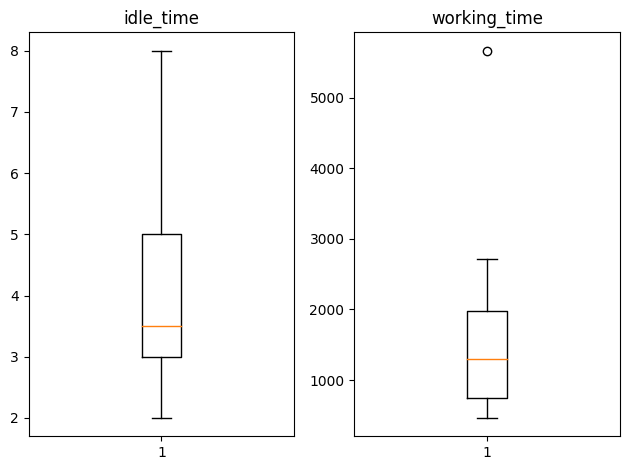

In [ ]:
fig, axes = plt.subplots(ncols=2)
for i, column in enumerate(['idle_time','working_time']):
    axes[i].boxplot(df[column])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

> working_time ha un outlier in quanto il worker mentre eseguiva la task si è disconnesso dalla piattaforma in quanto il pc richiedeva un aggiornamento. Successivamente è riuscito a riprendere la normale esecuzione

## workers_questionnaire

In [ ]:
workers_questionnaire = pd.read_csv("/content/workers_questionnaire.csv")
#workers_questionnaire.info()
# categorizzare gli utenti in base a genere eta ecc
# question_answer_text contiene il valore selezionato dal worker
display(workers_questionnaire.groupby('unit_id').count())
interesting_columns = ['worker_id','unit_id','questionnaire_type','questionnaire_time_elapsed',
                       'question_attribute_name','question_attribute_text',
                       'question_answer_value','question_answer_text']
workers_questionnaire = workers_questionnaire[interesting_columns]

### STANDARD

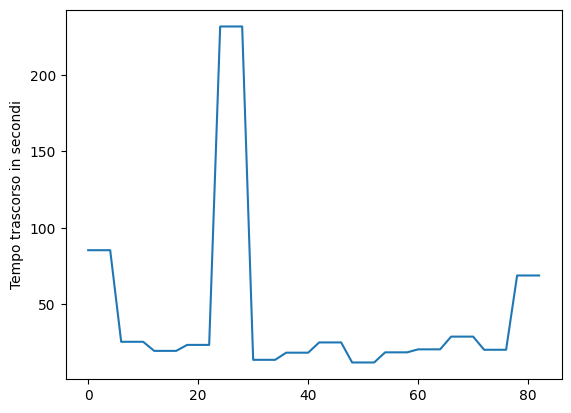

In [48]:
Standard_Answers = workers_questionnaire[workers_questionnaire['questionnaire_type'] == 'standard']
#display(CRT_Answers)
plt.plot(Standard_Answers['questionnaire_time_elapsed'])
plt.ylabel("Tempo trascorso in secondi")
plt.show()

In [70]:
questions = list(Standard_Answers['question_attribute_text'].unique())
questions
question_answers_labels = list(Standard_Answers['question_answers_labels'].unique())

questions_mapping = [  (quest, vals.split(':::') ) for quest, vals in zip(questions,question_answers_labels)]


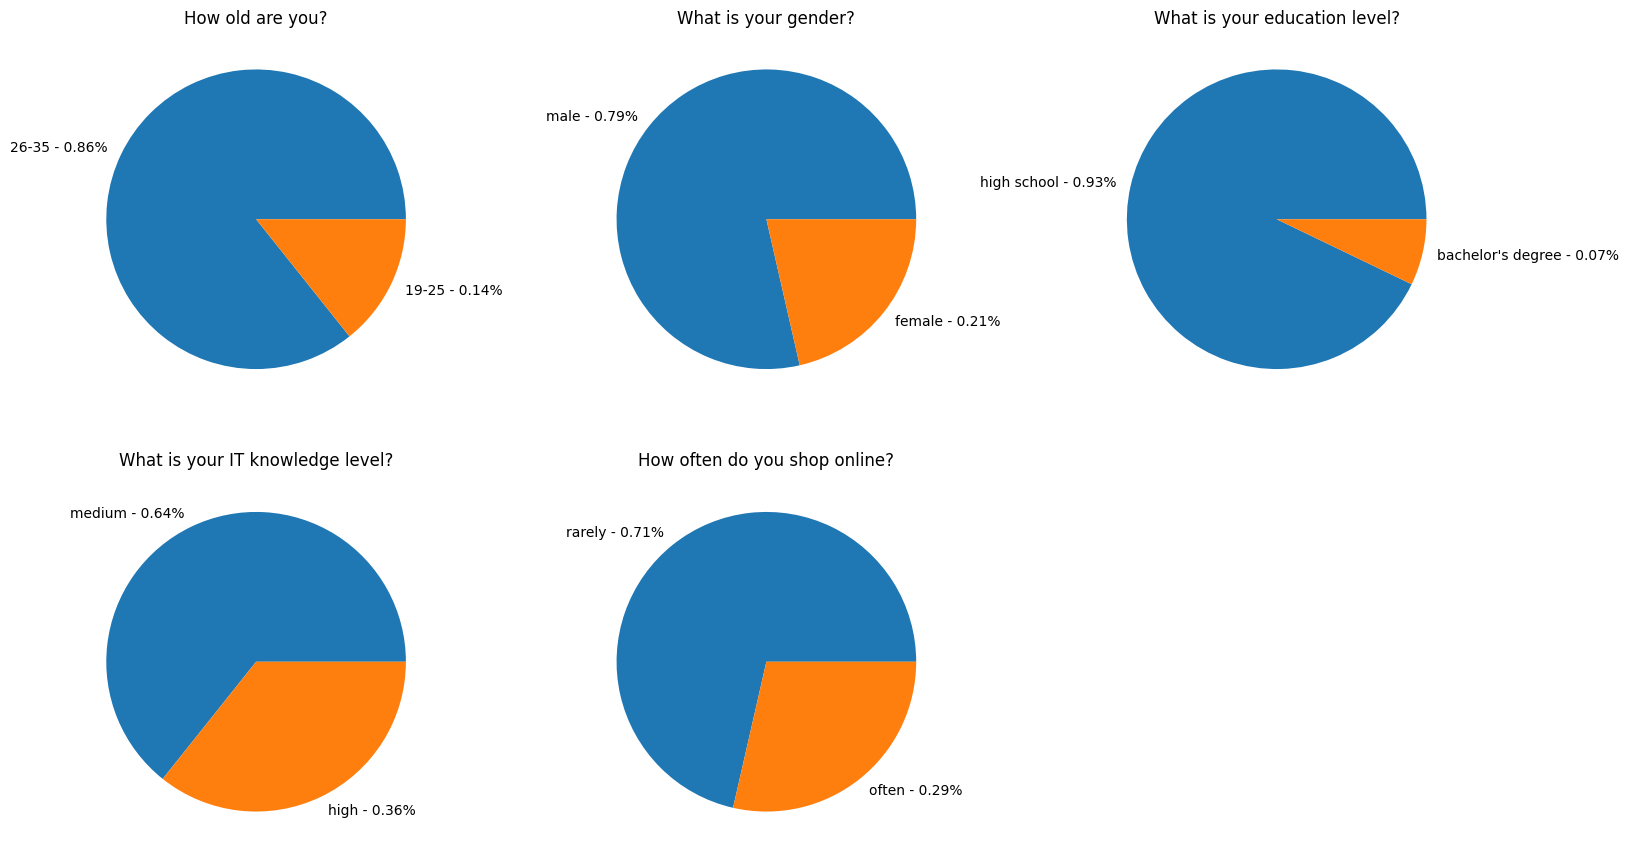

In [75]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(16,9)
quest_count = 0
for i in range(2):
    for j in range(3):
        if (i+j==3):
            axes[i,j].plot()
        else:
            curr_quest = questions[quest_count]
            quest_count = quest_count+1
            unique_values = list(Standard_Answers[Standard_Answers['question_attribute_text'] == curr_quest]['question_answer_text'].unique())
            freq_rel = Standard_Answers[Standard_Answers['question_attribute_text'] == curr_quest]['question_answer_text'].value_counts(normalize=True)
            custom_labels = [f'{answ_val} - {round(freq_val,2)}%' for answ_val,freq_val in  zip(unique_values, freq_rel)]
            axes[i,j].pie(freq_rel,labels=custom_labels)
            axes[i,j].set_title(curr_quest)

fig.delaxes(axes[1, 2]) #elimina l'ultimo plot vuoto
# Adjust spacing between subplots
plt.tight_layout()
plt.show()

### CRT

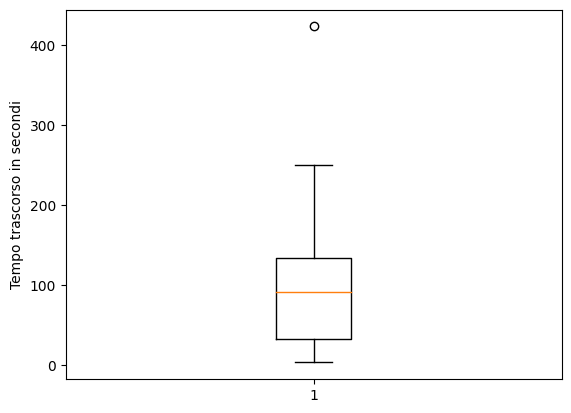

In [20]:
CRT_Answers = workers_questionnaire[workers_questionnaire['questionnaire_type'] == 'crt']
#display(CRT_Answers)
plt.boxplot(CRT_Answers['questionnaire_time_elapsed'])
plt.ylabel("Tempo trascorso in secondi")
plt.show()

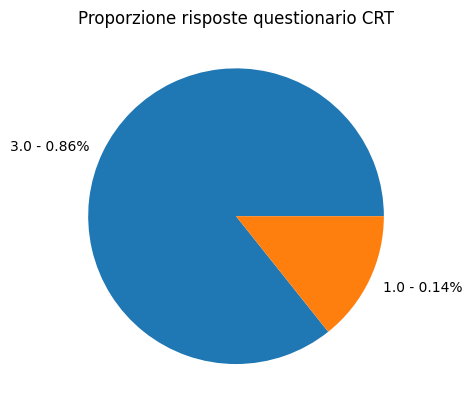

In [44]:
unique_values = list(CRT_Answers['question_answer_value'].unique())
freq_rel = list(CRT_Answers['question_answer_value'].value_counts(normalize=True))
custom_labels = [f'{answ_val} - {round(freq_val,2)}%' for answ_val,freq_val in  zip(unique_values, freq_rel)]
plt.pie(freq_rel,labels = custom_labels)
plt.title("Proporzione risposte questionario CRT")
plt.show()

b. Calcolate le frequenze relative delle risposte date dai lavoratori al questionario  
> File workers_questionnaire.csv


## workers_answers

In [91]:
workers_answers = pd.read_csv("/content/workers_answers.csv")
#workers_answers.info()
# print(workers_answers.groupby('unit_id').count())
# la unit_9 contiene 9 righe
# ordinare per tempo decrescente per document_index per gestire gli eventuali passi indietro
# mantenere worker_id, unit_id, action, document_index, (label,value) per ogni dimensione

### DATI INTERESSANTI

In [92]:
interesting_columns = ['worker_id','unit_id','action']
time_values = ['time_start','time_end','time_elapsed']
interesting_columns = interesting_columns + time_values
interesting_columns = interesting_columns + ['document_index','document_id']


In [93]:
import json

with open('/content/dimensions.json', 'r') as f:
    # Load the JSON data
    dimensions = json.load(f)

# Print the data
dimension_names  = [dim['name'] for dim in dimensions]
print(dimension_names)

dimension_names.pop() #rimuove ultimo elemento 'confidence' gestito separatamente
print(dimension_names)

['reliability', 'neutrality', 'comprehensibility', 'precision', 'completeness', 'informativeness', 'confidence']
['reliability', 'neutrality', 'comprehensibility', 'precision', 'completeness', 'informativeness']


In [94]:
# per ogni dimensione salvare dimension_label e dimension_value
dimension_columns = [[name+"_label",name+"_value"] for name in dimension_names]
dimension_columns = [item for sublist in dimension_columns for item in sublist]
interesting_columns = interesting_columns + dimension_columns + ['confidence_value','confidence_justification']
# aggiungere confidence_value e confidence_justification
print(interesting_columns)

['worker_id', 'unit_id', 'action', 'time_start', 'time_end', 'time_elapsed', 'document_index', 'document_id', 'reliability_label', 'reliability_value', 'neutrality_label', 'neutrality_value', 'comprehensibility_label', 'comprehensibility_value', 'precision_label', 'precision_value', 'completeness_label', 'completeness_value', 'informativeness_label', 'informativeness_value', 'confidence_value', 'confidence_justification']


In [95]:
workers_answers = workers_answers[interesting_columns]
# conversione valori int to float
workers_answers['reliability_value'] = workers_answers['reliability_value'].astype(float)
workers_answers['neutrality_value'] = workers_answers['neutrality_value'].astype(float)
workers_answers['comprehensibility_value'] = workers_answers['comprehensibility_value'].astype(float)
workers_answers['precision_value'] = workers_answers['precision_value'].astype(float)
workers_answers['completeness_value'] = workers_answers['completeness_value'].astype(float)
workers_answers['informativeness_value'] = workers_answers['informativeness_value'].astype(float)
workers_answers['confidence_value'] = workers_answers['confidence_value'].astype(float)

### RAGGRUPPAMENTO

> Si possono raggruppare i dati sia per worker_id che per unit_id, essendoci un'associazione unica (worker_id,unit_id)

> La funzione di aggregazione può essere custom tramite .transform(lambda x: (x - x.mean()) / x.std())

In [96]:
workers_answers[['unit_id','worker_id','action']].groupby(['worker_id','unit_id']).count()

,,action
worker_id,unit_id,
A11Y63SZ5XIO13,unit_13,5
A12BAB3WKXPE18,unit_12,5
A1E1R8IG1MHWJB,unit_5,5
A2OUE4SFMS3JC1,unit_7,5
A364H7U9O2GPP8,unit_8,5
A394QKKWXBAV95,unit_0,5
A3ATQJBTE9UGYO,unit_6,5
A3B5NBCZC7QOLG,unit_14,5
A3E48QYD5WGHXT,unit_9,9


> L'utente A3E48QYD5WGHXT ha effettuato 9 passaggi (action) totali, tra cui Next e Back tra le varie review (document_id, document_index)

### ANALISI CONFIDENCE

> L'utente A3E48QYD5WGHXT nella unit_9 ha cambiato idea sul valore di confidence per la prima review, quindi aggregando si può fare la media dei due valori

In [97]:
unit9_values = workers_answers[workers_answers['unit_id'] == 'unit_9']
# raggruppa le righe per document_index, quindi che si riferiscono alla stessa review
# rimuove le colonne non numeriche
# effettua la media aritmetica tra i valori di righe diverse con lo stesso document_index
left_df = unit9_values.sort_values('document_index').groupby('document_index').mean(numeric_only=True)

In [98]:
rightDF = unit9_values.drop_duplicates('document_index')
df_merged = left_df.merge(rightDF, on='document_index', how='left', suffixes=('', '_drop'))
df_merged.drop([col for col in df_merged.columns if 'drop' in col], axis=1, inplace=True)
df_merged['action'] = ["Next"]*4+['Finish']
display(df_merged)

,document_index,time_start,time_end,time_elapsed,reliability_value,neutrality_value,comprehensibility_value,precision_value,completeness_value,informativeness_value,...,unit_id,action,document_id,reliability_label,neutrality_label,comprehensibility_label,precision_label,completeness_label,informativeness_label,confidence_justification
0,0,1.705335e+09,1.705335e+09,114.295,1.0,-1.0,2.0,0.0,1.0,-1.0,...,unit_9,Next,Pair_ARQT4BAVJQOF5-B000FPAN2K,partially-agree,partially-disagree,completely-agree,neutral,partially-agree,partially-disagree,"The buyer doesn't say much about the product, ..."
1,1,1.705335e+09,1.705335e+09,28.845,1.0,-1.0,1.0,-1.0,0.0,0.0,...,unit_9,Next,Pair_AP4CTAPYQ0G38-B00IQCHQPQ,partially-agree,partially-disagree,partially-agree,partially-disagree,neutral,neutral,"The buyer doesn't say much about the product, ..."
2,2,1.705335e+09,1.705335e+09,174.780,1.0,-1.0,1.0,1.0,1.0,1.0,...,unit_9,Next,Pair_A16IOM7V3PNJ43-B0033SHDSS,partially-agree,partially-disagree,partially-agree,partially-agree,partially-agree,partially-agree,I think it is reliable because it compares oth...
3,3,1.705335e+09,1.705335e+09,75.530,1.0,1.0,1.0,0.0,1.0,1.0,...,unit_9,Next,Pair_A21VR3CU76PEA7-B003BZQRV2,partially-agree,partially-agree,partially-agree,neutral,partially-agree,partially-agree,I think it is reliable because the reviewer ex...
4,4,1.705335e+09,1.705335e+09,41.355,1.0,1.0,1.0,1.0,1.0,2.0,...,unit_9,Finish,Pair_A24FAUV92Z4NQ2-B0076O41IK,partially-agree,partially-agree,partially-agree,partially-agree,partially-agree,completely-agree,I think it is reliable because the reviewer ex...


> Per ciascuna dimension è stata calcolata la media tra i vari valori, e poi la tabella è stata aggregata per 'document_index', che corrisponde al n° della review valutata, ottenendo 5 righe e tutte le colonne

> I dati delle risposte vengono aggiornati

In [99]:
workers_answers = workers_answers[workers_answers['unit_id'] != 'unit_9']
workers_answers = pd.concat([workers_answers,df_merged],ignore_index=True)
workers_answers[['unit_id','worker_id','action']].groupby(['worker_id','unit_id']).count()

,,action
worker_id,unit_id,
A11Y63SZ5XIO13,unit_13,5
A12BAB3WKXPE18,unit_12,5
A1E1R8IG1MHWJB,unit_5,5
A2OUE4SFMS3JC1,unit_7,5
A364H7U9O2GPP8,unit_8,5
A394QKKWXBAV95,unit_0,5
A3ATQJBTE9UGYO,unit_6,5
A3B5NBCZC7QOLG,unit_14,5
A3E48QYD5WGHXT,unit_9,5


> Ora ogni worker_id ha esattamente 5 valori

### ANALISI TIME_ELAPSED

> Tempo per valutare una singola review

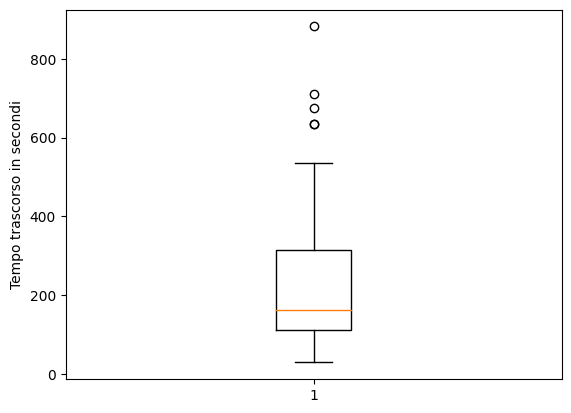

In [ ]:
plt.boxplot(workers_answers['time_elapsed'])
plt.ylabel("Tempo trascorso in secondi")
plt.show()

### CONFIDENCE MEDIA PER OGNI REVIEW

In [ ]:
review_mean_confidence = workers_answers[['worker_id','confidence_value']].groupby('worker_id').mean()
review_mean_confidence.to_csv('/content/review_mean_confidence.csv')
plt.boxplot(review_mean_confidence['confidence_value'])
plt.title('Distribuzione Confidence tra i vari worker')
plt.show()
review_mean_confidence


### TEMPO MEDIO ESECUZIONE REVIEW

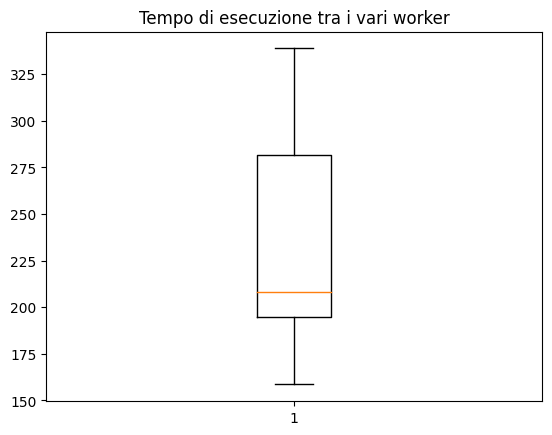

,time_elapsed
document_id,
Pair_A13PCJYZZSHTF1-B00RMX6EB2,238.9400
Pair_A16IOM7V3PNJ43-B0033SHDSS,189.4120
Pair_A1BCTPXWBGVOM3-B01FYFJ1CS,338.8340
Pair_A1IXR1SDY2JEBT-B018J40IKU,158.5825
Pair_A21VR3CU76PEA7-B003BZQRV2,274.4180
Pair_A24FAUV92Z4NQ2-B0076O41IK,163.3210
Pair_A2ZHSXTQO831OS-B000Q9A4AQ,208.1400
Pair_A32FTLA25H2AM-B018FNDPVY,294.4125
Pair_A87LMJTA3I6UU-B00336EUU4,288.4450


In [112]:
review_mean_timeexec = workers_answers[['document_id','time_elapsed']].groupby('document_id').mean()
review_mean_timeexec.to_csv('/content/review_mean_timeexec.csv')
plt.boxplot(review_mean_timeexec['time_elapsed'])
plt.title('Tempo di esecuzione tra i vari worker')
plt.show()
review_mean_timeexec

### AGGREGAZIONE VALUTAZIONE DIMENSIONI PER OGNI REVIEW

#### MODA

In [118]:
interesting_columns = ['document_id'] + [ dim+"_value" for dim in dimension_names]
workers_answers = workers_answers[interesting_columns]

In [123]:
from scipy import stats
def custom_aggr(data):
    mode_value = stats.mode(data)
    return (mode_value.mode)

mode_aggr = workers_answers.groupby('document_id').agg(custom_aggr).sort_values('document_id')
mode_aggr

,reliability_value,neutrality_value,comprehensibility_value,precision_value,completeness_value,informativeness_value
document_id,,,,,,
Pair_A13PCJYZZSHTF1-B00RMX6EB2,0.0,-2.0,2.0,-2.0,-2.0,-1.0
Pair_A16IOM7V3PNJ43-B0033SHDSS,0.0,-1.0,1.0,0.0,-1.0,1.0
Pair_A1BCTPXWBGVOM3-B01FYFJ1CS,-1.0,0.0,1.0,1.0,1.0,0.0
Pair_A1IXR1SDY2JEBT-B018J40IKU,1.0,0.0,1.0,0.0,0.0,1.0
Pair_A21VR3CU76PEA7-B003BZQRV2,0.0,1.0,0.0,0.0,-1.0,1.0
Pair_A24FAUV92Z4NQ2-B0076O41IK,0.0,1.0,1.0,1.0,1.0,2.0
Pair_A2ZHSXTQO831OS-B000Q9A4AQ,1.0,1.0,1.0,1.0,0.0,1.0
Pair_A32FTLA25H2AM-B018FNDPVY,-1.0,-1.0,1.0,1.0,1.0,1.0
Pair_A87LMJTA3I6UU-B00336EUU4,1.0,1.0,1.0,0.0,1.0,2.0


#### MEDIA

In [129]:
import math
def custom_aggr(data):
    return float(round(data.mean()))

mean_aggr = workers_answers.groupby('document_id').agg(custom_aggr).sort_values('document_id')
mean_aggr

,reliability_value,neutrality_value,comprehensibility_value,precision_value,completeness_value,informativeness_value
document_id,,,,,,
Pair_A13PCJYZZSHTF1-B00RMX6EB2,0.0,-2.0,2.0,-2.0,-1.0,-1.0
Pair_A16IOM7V3PNJ43-B0033SHDSS,0.0,-1.0,1.0,0.0,-1.0,0.0
Pair_A1BCTPXWBGVOM3-B01FYFJ1CS,0.0,0.0,1.0,1.0,1.0,1.0
Pair_A1IXR1SDY2JEBT-B018J40IKU,0.0,0.0,1.0,0.0,0.0,0.0
Pair_A21VR3CU76PEA7-B003BZQRV2,0.0,0.0,1.0,0.0,-1.0,0.0
Pair_A24FAUV92Z4NQ2-B0076O41IK,0.0,1.0,1.0,0.0,1.0,2.0
Pair_A2ZHSXTQO831OS-B000Q9A4AQ,1.0,0.0,1.0,0.0,0.0,0.0
Pair_A32FTLA25H2AM-B018FNDPVY,0.0,0.0,0.0,1.0,0.0,1.0
Pair_A87LMJTA3I6UU-B00336EUU4,1.0,1.0,2.0,1.0,1.0,1.0


#### CONFRONTO


In [130]:
mean_aggr == mode_aggr

,reliability_value,neutrality_value,comprehensibility_value,precision_value,completeness_value,informativeness_value
document_id,,,,,,
Pair_A13PCJYZZSHTF1-B00RMX6EB2,True,True,True,True,False,True
Pair_A16IOM7V3PNJ43-B0033SHDSS,True,True,True,True,True,False
Pair_A1BCTPXWBGVOM3-B01FYFJ1CS,False,True,True,True,True,False
Pair_A1IXR1SDY2JEBT-B018J40IKU,False,True,True,True,True,False
Pair_A21VR3CU76PEA7-B003BZQRV2,True,False,False,True,True,False
Pair_A24FAUV92Z4NQ2-B0076O41IK,True,True,True,False,True,True
Pair_A2ZHSXTQO831OS-B000Q9A4AQ,True,False,True,False,True,False
Pair_A32FTLA25H2AM-B018FNDPVY,False,False,False,True,False,True
Pair_A87LMJTA3I6UU-B00336EUU4,True,True,False,False,True,False


## workers_dimension_selection

In [77]:
workers_dimensions_selection = pd.read_csv("/content/workers_dimensions_selection.csv")
interesting_columns = ['worker_id','unit_id','selection_value','document_id']
workers_dimensions_selection = workers_dimensions_selection[interesting_columns]
workers_dimensions_selection.info()
# media della confidence_value per ogni review
# worker_id, unit_id, , selection_value in base all'ultimo selection_index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   worker_id        126 non-null    object
 1   unit_id          126 non-null    object
 2   selection_value  126 non-null    int64 
 3   document_id      126 non-null    object
dtypes: int64(1), object(3)
memory usage: 4.1+ KB


In [80]:
review_mean_confidence = workers_dimensions_selection.groupby('document_id').mean()
review_mean_confidence.to_csv('/content/review_mean_confidence.csv')

## workers_documents

In [ ]:
# worker_documents.csv
# mantenere worker_ids (lista dei worker che hanno lavorato), unit_ids (lista delle unità in cui è presente la review)
# product_id = Review_ID
workers_documents = pd.read_csv("result/ProgettoSocial/DataFrame/workers_documents.csv")
workers_documents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   document_id    15 non-null     object
 1   text           15 non-null     object
 2   product_title  15 non-null     object
 3   product_brand  15 non-null     object
 4   time           15 non-null     object
 5   task_type      15 non-null     object
 6   unit_ids       15 non-null     object
 7   worker_ids     15 non-null     object
dtypes: object(8)
memory usage: 1.1+ KB



c. Calcolate il percent agreement tra worker per i valori forniti rispetto a ciascuna
dimensione categoriale
d. Calcolate la confidence media espressa dai worker nel valutare ciascuna
recensione
e. Calcolate il tempo medio impiegato dai worker per valutare ciascuna recensione
f. Descrivete brevemente le considerazioni tratte dall’analisi dei dati prodotti dai worker
○ Quali sono le caratteristiche demografiche e culturali dei lavoratori che potete
dedurre dal questionario?
○ Vi è accordo tra ciascun lavoratore? Per quali dimensioni vi è più accordo?
Per quali meno?
○ …
g. Aggiungete eventuali altre analisi che ritenete opportune ed utili con i dati che avete
a disposizione
a disposizione